## Install the repo

In [ ]:
!git clone -b adaptive_reranking --single-branch --recursive https://github.com/Digre01/Visual-Place-Recognition-Project.git


In [ ]:
%cd Visual-Place-Recognition-Project/image-matching-models
!pip install -e .[all]

In [4]:
!pip install faiss-cpu
!pip install yacs
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 77.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.4 MB/s eta 0:00:00


## Download datasets

In [2]:
%cd Visual-Place-Recognition-Project/

/kaggle/working/Visual-Place-Recognition-Project


In [7]:
!python download_datasets.py

Downloading...
From (original): https://drive.google.com/uc?id=15QB3VNKj93027UAQWv7pzFQO1JDCdZj2
From (redirected): https://drive.google.com/uc?id=15QB3VNKj93027UAQWv7pzFQO1JDCdZj2&confirm=t&uuid=c49d9eee-05f3-4cc3-9612-c16dfb700352
To: /kaggle/working/data/tokyo_xs.zip
100%|█████████████████████████████████████████| 141M/141M [00:00<00:00, 254MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tQqEyt3go3vMh4fj_LZrRcahoTbzzH-y
From (redirected): https://drive.google.com/uc?id=1tQqEyt3go3vMh4fj_LZrRcahoTbzzH-y&confirm=t&uuid=22136a85-1051-427e-ad68-ce2dc6acc015
To: /kaggle/working/data/sf_xs.zip
100%|███████████████████████████████████████| 1.03G/1.03G [00:04<00:00, 244MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16iuk8voW65GaywNUQlWAbDt6HZzAJ_t9
From (redirected): https://drive.google.com/uc?id=16iuk8voW65GaywNUQlWAbDt6HZzAJ_t9&confirm=t&uuid=91bb4d63-f27d-4a84-86e8-d877fb3947af
To: /kaggle/working/data/svox.zip
100%|███████████████████████████

## Pipeline

In [ ]:
CONFIGS = [
    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "loftr", dataset: "svox_night", data_path: "data/svox/images/train/gallery", queries_path: "data/svox/images/train/queries_night"},
    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "loftr", dataset: "svox_sun", data_path: "data/svox/train/images/gallery", queries_path: "data/svox/images/train/queries_sun"},

    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "superpoint-lg", dataset: "svox_night", data_path: "data/svox/images/train/gallery", queries_path: "data/svox/images/train/queries_night"},
    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "superpoint-lg",  dataset: "svox_sun", data_path: "data/svox/train/images/gallery", queries_path: "data/svox/images/train/queries_sun"},

    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "loftr", dataset: "svox_night", data_path: "data/svox/images/train/gallery", queries_path: "data/svox/images/train/queries_night"},
    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "loftr",  dataset: "svox_sun", data_path: "data/svox/train/images/gallery", queries_path: "data/svox/images/train/queries_sun"},
    
    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "superpoint-lg", dataset: "svox_night", data_path: "data/svox/images/train/gallery", queries_path: "data/svox/images/train/queries_night"}
    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "superpoint-lg",  dataset: "svox_sun", data_path: "data/svox/train/images/gallery", queries_path: "data/svox/images/train/queries_sun"}
]



### Training logistic regressors

In [ ]:

import os
import shutil

for conf in CONFIGS:
    v_name = conf["vpr"]
    m_name = conf["matcher"]
    d_name = conf["dataset"]
    database_path = conf["data_path"]
    queries_path = conf["queries_path"]
    log_tag = f"train_{v_name}_{d_name}"
    
    print(f"\n{'='*60}\Running: {v_name.upper()} + {m_name.upper()}\n{'='*60}")
    
    #RETRIVAL
    !python VPR-methods-evaluation/main.py \
        --method={v_name} --backbone={conf['backbone']} --descriptors_dimension={conf['dim']} \
        --num_workers 4 --batch_size 32 \
        --log_dir {log_tag} \
        --image_size 512 512 \
        --database_folder database_path \
        --queries_folder queries_path \
        --recall_values 1 5 10 20 --num_preds_to_save 20
    

    base_log = f"logs/{log_tag}"
    latest_run = sorted(os.listdir(base_log))[-1]
    preds_dir = os.path.join(base_log, latest_run, "preds")
    

    #MATCHING
    out_inliers = f"inliers_full_{v_name}_{m_name}_{d_name}"
    
    !python match_queries_preds.py \
        --preds-dir {preds_dir} \
        --out-dir {out_inliers} \
        --matcher {m_name} \
        --num-preds 20
    
################ Logistic regressor training #######################################
    
csv_file = f"dataset_{v_name}_{m_name}_{d_name}.csv"
model_file = f"model_{v_name}_{m_name}_.{d_name}.joblib"


!python prepare_logistic_data.py --preds-dir {preds_dir} --inliers-dir {out_inliers} --output-csv {csv_file}
!python train_logReg.py --csv-path {csv_file} --model-out {model_file}



## Visualization

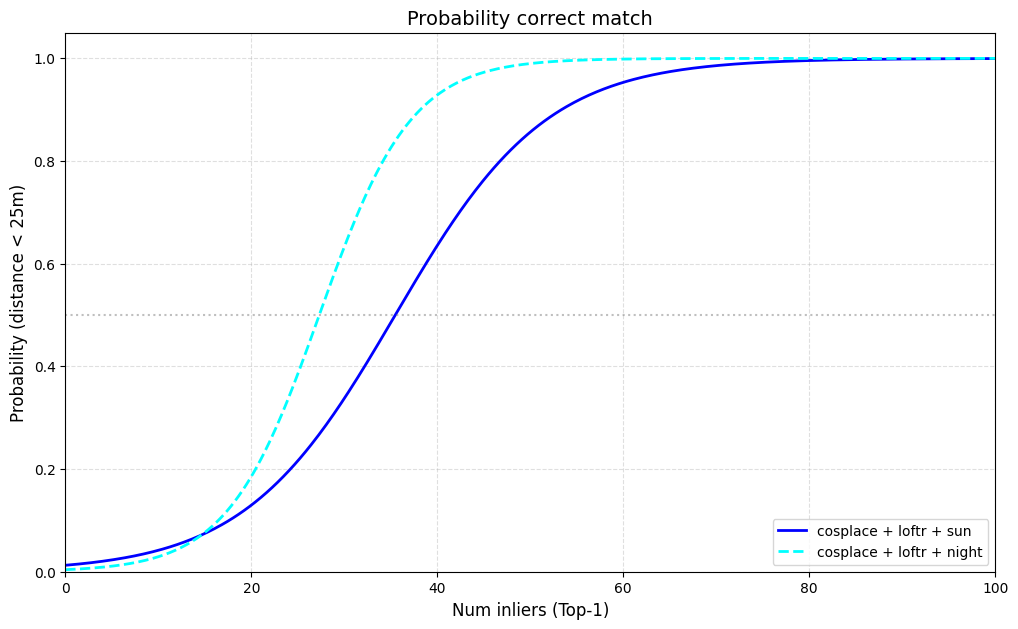

In [ ]:
#Visualize the sigmoid of the logistic regressor

import numpy as np
import matplotlib.pyplot as plt
import joblib
import glob
import os


plt.figure(figsize=(12, 7))

x_test = np.linspace(0, 100, 500).reshape(-1, 1)

colors = ['blue', 'cyan', 'red', 'orange']
styles = ['-', '--', '-', '--']

for i, conf in enumerate(CONFIGS):
    m_path = f"model_{conf['vpr']}_{conf['matcher']}_{conf['type']}.joblib"
    if os.path.exists(m_path):
        model = joblib.load(m_path)
        
        #Probability P(y=1 | x)
        probs = model.predict_proba(x_test)[:, 1]
        
        label = f"{conf['vpr']} + {conf['matcher']} + {conf['type']}"
        plt.plot(x_test, probs, label=label, color=colors[i], linestyle=styles[i], lw=2)

plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.title("Probability correct match", fontsize=14)
plt.xlabel("Num inliers (Top-1)", fontsize=12)
plt.ylabel("Probability (distance < 25m)", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.legend(loc='lower right', fontsize=10)
plt.xlim(0, 100) 
plt.ylim(0, 1.05)

plt.savefig("logistic_comparison.png")
plt.show()

## Validation

### Extracting validation csv

In [ ]:
import os
import shutil

#Validation is done using the only available validation dataset
val_database_path = 'data/sf_xs/val/database'
val_queries_path = 'data/sf_xs/val/queries'

for conf in CONFIGS:
    v_name = conf["vpr"]
    m_name = conf["matcher"]
    log_tag = f"train_{v_name}"  
    
    print(f"\n{'='*60} Running: {v_name.upper()} + {m_name.upper()}\n{'='*60}")
    
    
    !python VPR-methods-evaluation/main.py \
        --method={v_name} --backbone={conf['backbone']} --descriptors_dimension={conf['dim']} \
        --num_workers 4 --batch_size 32 \
        --log_dir {log_tag} \
        --image_size 512 512 \
        --database_folder val_database_path \
        --queries_folder val_queries_path \
        --recall_values 1 5 10 20 --num_preds_to_save 20
    

    base_log = f"logs/{log_tag}"
    latest_run = sorted(os.listdir(base_log))[-1]
    preds_dir = os.path.join(base_log, latest_run, "preds")
    print(preds_dir)
    
    out_inliers = f"inliers_full_{v_name}_{m_name}"
    !python match_queries_preds.py \
        --preds-dir {preds_dir} \
        --out-dir {out_inliers} \
        --matcher {m_name} \
        --num-preds 20
    

    #Saving the csv
    csv_file = f"dataset_{v_name}_{m_name}_validation.csv"
    
    !python prepare_logistic_data.py --preds-dir {preds_dir} --inliers-dir {out_inliers} --output-csv {csv_file}


============================================================ Running: COSPLACE + SUPERPOINT-LG
logs/train_cosplace/2026-01-24_18-04-37/preds
/kaggle/working/Visual-Place-Recognition-Project/image-matching-models/matching/third_party/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
100%|█████████████████████████████████████| 7993/7993 [6:00:05<00:00,  2.70s/it]
Total time: 21605.48s
Match: 159860 over 159860
Dataset creato con 7993 campioni -> dataset_cosplace_superpoint-lg_validation.csv


### Predict Probabilistic threshold

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import precision_score

#We want to find the number of inliers that gave us 99% of the full performance

thresholds = np.linspace(0.1, 0.95, 18)
target_precision = 0.99  #Minimum Precision for TOP-1


for conf in CONFIGS:

    v_name, m_name = conf["vpr"], conf["matcher"]
    model_file =  "model_cosplace_loftr_night.joblib"
    validation_csv = f"dataset_{v_name}_{m_name}_validation.csv"

try:
    model = joblib.load(model_file)
    df = pd.read_csv(validation_csv)

    
    probs = model.predict_proba(df[['num_inliers']].values)[:, 1]
    
    best_t, max_savings = 0.5, 0.0
    
    for t in thresholds:
        preds = (probs >= t).astype(int)
        precision = precision_score(df['label'], preds, zero_division=0)
        
        if precision >= target_precision:
            #1 match if stopped, 20 matches otherwise
            avg_matches = np.mean([1 if p == 1 else 20 for p in preds])
            savings = (1 - (avg_matches / 20)) * 100
            if savings >= max_savings:
                max_savings = savings
                best_t = t

    
    
    # to find the corrispondent number of inliers
    # we extract the model parameters
    # and we compute the log-odds (logit), to invert the sigmoid
    #and then compute b0​+b1​⋅x to extract the "starting value"
    
    b0 = model.intercept_[0]
    b1 = model.coef_[0][0]
    
    logit_t = np.log(best_t / (1 - best_t))
    inliers_threshold = (logit_t - b0) / b1

    print(f"{v_name.upper()} + {m_name.upper()}")
    print(f"Selected Probabilistic threshold: {best_t:.2f}")
    print(f"Selected Inliers threshold: {inliers_threshold:.2f}")
                    
except FileNotFoundError:
    print("Error: file not found")

NETVLAD + LOFTR
Selected Probabilistic threshold: 0.65
Selected Inliers threshold: 30.37


## Testing

In [ ]:
CONFIGS = [
    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "loftr"},
    {"vpr": "cosplace", "backbone": "ResNet18", "dim": 512, "matcher": "superpoint-lg"},
    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "loftr"},
    {"vpr": "netvlad", "backbone": "VGG16", "dim": 4096, "matcher": "superpoint-lg"}
]


TEST_DATASET = [
    {"name": "tokyo_xs",  "dataset_path": "data/tokyo_xs/test/database", "queries_path": "data/tokyo_xs/test/queries"}
    {"name": "sf_xs",  "dataset_path": "data/sf_xs/test/database", "queries_path": "data/sf_xs/test/queries"}
    {"name": "svox_sun", "database_path": "data/svox/images/test/gallery", "queries_path": "data/svox/images/test/queries_sun"}
    {"name": "svox_nigth", "database_path": "data/svox/images/test/gallery", "queries_path": "data/svox/images/test/queries_sun"}
] 

for dataset in TEST_DATASET:
    for conf in CONFIGS:

        log_tag = f"train_{conf['vpr']}_{conf['dataset']}"

        !python VPR-methods-evaluation/main.py \
                --method={conf['vpr']} --backbone={conf['backbone']} --descriptors_dimension={conf['dim']} \
                --num_workers 4 --batch_size 32 \
                --log_dir {log_tag} \
                --image_size 512 512 \
                --database_folder dataset['database_path'] \
                --queries_folder dataset['queries_path'] \
                --recall_values 1 5 10 20 --num_preds_to_save 20

python3: can't open file '/kaggle/working/Visual-Place-Recognition-Project/VPR-methods-evaluation/main.py': [Errno 2] No such file or directory


In [ ]:
!python match_queries_preds.py \
    --preds-dir 'path_to_the_prediction' \
    --matcher 'matcher-mame' \
    --device 'cuda' \
    --num-preds 20 \
    --logistic-model-path 'model_file_path.joblib' \
    --logistic-prob-threshold 'probability that you got from the validation'

/kaggle/working/Visual-Place-Recognition-Project/image-matching-models/matching/third_party/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
100%|█████████████████████████████████████████| 315/315 [04:56<00:00,  1.06it/s]
Total time: 296.40s
Match: 2842 over 6300


In [ ]:
!python adaptive_reranking.py  \
    --preds-dir 'path_to_the_prediction' \
    --inliers-dir 'path_to_the_prediction + "_matcher-name"' \
    --num-preds 20 


Eval over 315 query...
100%|████████████████████████████████████████| 315/315 [00:00<00:00, 887.36it/s]

RESULTS RE-RANKING ADAPTIVE
Baseline (Retrieval-only) R@1: 65.08%
Adaptive Matching R@1:       84.76%
Computational cost saving:    54.89%
---------------------------------------------
OTHER DATA:
Recall Adattive:
 R@1: 84.76%
 R@5: 87.94%
 R@10: 88.57%
 R@20: 89.52%
